## Work
1. 試比較 save_best_only 與否的差異
  
  when save_best_only is false the loss is worse and accuracy is unstable.
   
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

  Loss and accuracy appear to get worse.. why?

In [16]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [17]:
train, test = keras.datasets.cifar10.load_data()

In [18]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [19]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [20]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [21]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [22]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h6", 
                             monitor="val_loss", 
                             save_best_only=True,
                             save_weights_only=False)

model_ckpt2 = ModelCheckpoint(filepath="./tmp.h6", 
                             monitor="val_loss", 
                             save_best_only=True,
                             save_weights_only=True)
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# Load back
model = keras.models.load_model("./tmp.h6")

# Retrain and save weights only
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt2]
         )

loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 5s 109us/step - loss: 0.5189 - acc: 0.8532 - val_loss: 1.6812 - val_acc: 0.4875
Epoch 50/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.5039 - acc: 0.8597 - val_loss: 1.7040 - val_acc: 0.4884
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 131us/step - loss: 0.9604 - acc: 0.6779 - val_loss: 1.4951 - val_acc: 0.4900
Epoch 2/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.9397 - acc: 0.6872 - val_loss: 1.4956 - val_acc: 0.4885
Epoch 3/50
50000/50000 [==============================] - 6s 110us/step - loss: 0.9205 - acc: 0.6960 - val_loss: 1.4915 - val_acc: 0.4945
Epoch 4/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.9014 - acc: 0.7022 - val_loss: 1.4993 - val_acc: 0.4896
Epoch 5/50
50000/50000 [==============================] - 5s 107us/step - loss: 0.8803 - acc: 0.7098 - val_loss: 1.5130 - val_acc: 0

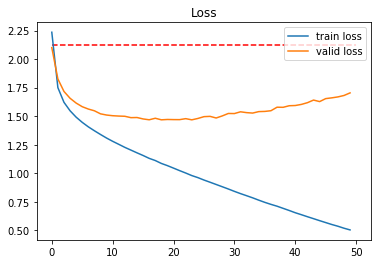

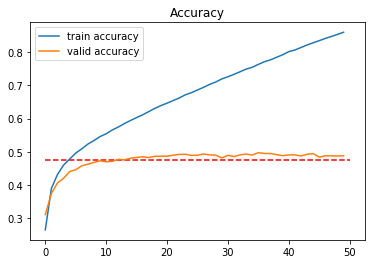

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()